# Prediksi Ketidakpatuhan Pasien (Versi Sederhana)

Notebook ini merangkum ulang alur kerja agar lebih sederhana dan mudah dipahami.

## Ringkasan Pipeline Baseline
1. Data loading
2. EDA & analisis imbalance
3. Preprocessing
4. Stratified 5-Fold CV
5. Train Logistic Regression
6. Train Decision Tree
7. Evaluate metrics
8. Analyze confusion matrix
9. ROC & PR curve
10. Interpretasi hasil

In [ ]:
# Import library inti
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    average_precision_score,
    confusion_matrix, ConfusionMatrixDisplay,
    RocCurveDisplay, PrecisionRecallDisplay,
 )

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline

In [ ]:
# Memuat data
df = pd.read_csv("Dataset-Imbalance/medication_adherence.csv")
print("Jumlah data:", df.shape)
df.head()

Jumlah data: (2800, 24)


,patient_id,age,gender,chronic_condition,medication_type,dosage,comorbidities,BMI,event_id,timestamp,...,blood_pressure,blood_glucose,activity_level,sleep_hours,stress_level,reminder_sent,reminder_response_time,social_support,location,future_non_adherence
0,P0103,45,M,diabetes,Metformin,50,0,24.8,E00000,2025-05-22 02:46:32,...,139/81,170.2,8030,5.2,3,1,15.0,0,work,0
1,P0436,79,M,hypertension,Metformin,500,0,25.2,E00001,2025-03-02 22:26:25,...,123/82,80.1,5338,8.8,2,1,94.0,0,home,0
2,P0861,71,F,diabetes,Salbutamol,20,3,28.6,E00002,2025-09-13 02:37:54,...,138/80,110.1,9021,5.6,4,1,86.0,2,hospital,0
3,P0271,89,M,hypertension,Atorvastatin,10,0,22.9,E00003,2025-01-26 03:54:55,...,122/84,157.2,4930,4.8,4,1,100.0,4,hospital,0
4,P0107,84,F,diabetes,Amlodipine,10,3,34.5,E00004,2025-02-20 03:28:37,...,125/79,147.3,5960,7.6,3,0,NaN,2,hospital,0


## EDA & Analisis Imbalance
- Cek distribusi target dan missing value sederhana.

future_non_adherence
0    2102
1     698
Name: count, dtype: int64

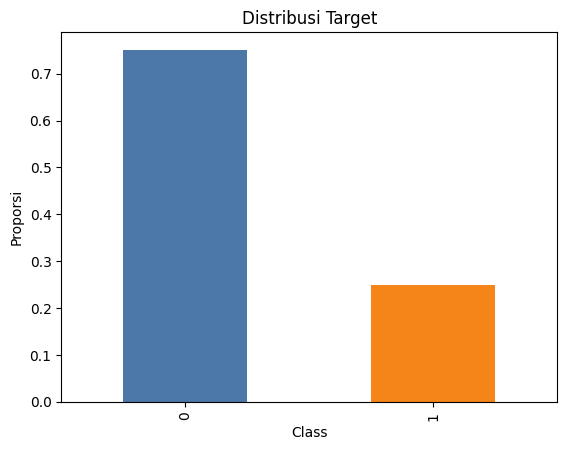

missed_reason             2393
reminder_response_time     834
dtype: int64

In [ ]:
# Distribusi target (imbalanced check)
target_counts = df["future_non_adherence"].value_counts().sort_index()
display(target_counts)
(target_counts / target_counts.sum()).plot(kind="bar", color=["#4C78A8", "#F58518"])
plt.title("Distribusi Target")
plt.xlabel("Class")
plt.ylabel("Proporsi")
plt.show()

# Ringkas missing value
missing = df.isna().sum().sort_values(ascending=False)
display(missing[missing > 0].head(10))

In [ ]:
# Fitur target dan kolom yang tidak dipakai
TARGET = "future_non_adherence"
DROP_COLS = ["patient_id", "event_id"]

# Rekayasa fitur sederhana
df["timestamp"] = pd.to_datetime(df["timestamp"])
df["hour"] = df["timestamp"].dt.hour
df["dayofweek"] = df["timestamp"].dt.dayofweek

# Memisahkan blood_pressure
df[["bp_systolic", "bp_diastolic"]] = (
    df["blood_pressure"].str.split("/", expand=True).astype(float)
)

# Menangani missing value sederhana
df["reminder_response_time"] = df["reminder_response_time"].fillna(-1)

In [ ]:
# Memisahkan fitur (X) dan target (y)
X = df.drop(columns=DROP_COLS + [TARGET, "timestamp", "blood_pressure"])
y = df[TARGET]

# Definisikan fitur kategorikal dan numerikal
categorical_features = ["gender", "chronic_condition", "medication_type", "location"]
numerical_features = [
    "age", "dosage", "BMI", "activity_level", "sleep_hours", "stress_level",
    "blood_glucose", "bp_systolic", "bp_diastolic", "reminder_sent",
    "reminder_response_time", "social_support", "hour", "dayofweek"
]

In [ ]:
# Train-test split (stratify agar proporsi kelas tetap)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train size:", X_train.shape, "| Test size:", X_test.shape)

Train size: (2240, 23) | Test size: (560, 23)


In [ ]:
# Preprocessing: OneHot untuk kategorikal, numerik diteruskan
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", "passthrough", numerical_features)
    ]
)

In [ ]:
# Daftar model sederhana (sesuai pipeline baseline)
models = {
    "LogReg_Balanced": LogisticRegression(
        class_weight="balanced", max_iter=1000, random_state=42
    ),
    "DecisionTree": DecisionTreeClassifier(
        class_weight="balanced", random_state=42
    ),
}

In [ ]:
# Stratified 10-Fold Cross Validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scoring = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1",
    "roc_auc": "roc_auc",
    "pr_auc": "average_precision",
}

cv_results = []
for name, model in models.items():
    cv_pipeline = Pipeline([
        ("preprocess", preprocessor),
        ("model", model),
    ])
    scores = cross_validate(
        cv_pipeline, X_train, y_train, cv=skf, scoring=scoring, n_jobs=-1
    )
    cv_results.append({
        "Model": name,
        "Accuracy": scores["test_accuracy"].mean(),
        "Precision": scores["test_precision"].mean(),
        "Recall": scores["test_recall"].mean(),
        "F1": scores["test_f1"].mean(),
        "ROC_AUC": scores["test_roc_auc"].mean(),
        "PR_AUC": scores["test_pr_auc"].mean(),
    })

cv_results_df = pd.DataFrame(cv_results).sort_values(by=["Recall", "F1"], ascending=False)
print("Hasil CV (10-Fold) - diurutkan dari recall tertinggi:")
cv_results_df

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:

Hasil CV (10-Fold) - diurutkan dari recall tertinggi:


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Model,Accuracy,Precision,Recall,F1,ROC_AUC,PR_AUC
0,LogReg_Balanced,0.518304,0.245224,0.451818,0.317314,0.505943,0.263693
1,DecisionTree,0.627679,0.265010,0.277727,0.270374,0.510750,0.254814


In [ ]:
# Evaluasi sederhana beberapa model (hold-out test set)
results = []

for name, model in models.items():
    pipeline = Pipeline([
        ("preprocess", preprocessor),
        ("model", model)
    ])
    pipeline.fit(X_train, y_train)

    y_proba = pipeline.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC_AUC": roc_auc_score(y_test, y_proba),
        "PR_AUC": average_precision_score(y_test, y_proba),
    })

results_df = pd.DataFrame(results).sort_values(by=["Recall", "F1"], ascending=False)
print("Hasil Evaluasi Model (diurutkan dari recall tertinggi):")
results_df

Hasil Evaluasi Model (diurutkan dari recall tertinggi):


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Model,Accuracy,Precision,Recall,F1,ROC_AUC,PR_AUC
0,LogReg_Balanced,0.507143,0.242424,0.457143,0.316832,0.496667,0.252481
1,DecisionTree,0.617857,0.253333,0.271429,0.262069,0.502381,0.250905


In [ ]:
# Pilih model terbaik berdasarkan recall & F1
best_model_name = results_df.iloc[0]["Model"]
best_model = models[best_model_name]
print("Model terbaik:", best_model_name)

final_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("model", best_model)
])
final_pipeline.fit(X_train, y_train)

y_proba_final = final_pipeline.predict_proba(X_test)[:, 1]
y_pred_final = (y_proba_final >= 0.5).astype(int)

print("\nEvaluasi akhir (test set):")
print("Accuracy :", round(accuracy_score(y_test, y_pred_final), 4))
print("Precision:", round(precision_score(y_test, y_pred_final, zero_division=0), 4))
print("Recall   :", round(recall_score(y_test, y_pred_final), 4))
print("F1-Score :", round(f1_score(y_test, y_pred_final), 4))
print("ROC-AUC  :", round(roc_auc_score(y_test, y_proba_final), 4))

Model terbaik: LogReg_Balanced

Evaluasi akhir (test set):
Accuracy : 0.5071
Precision: 0.2424
Recall   : 0.4571
F1-Score : 0.3168
ROC-AUC  : 0.4967


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


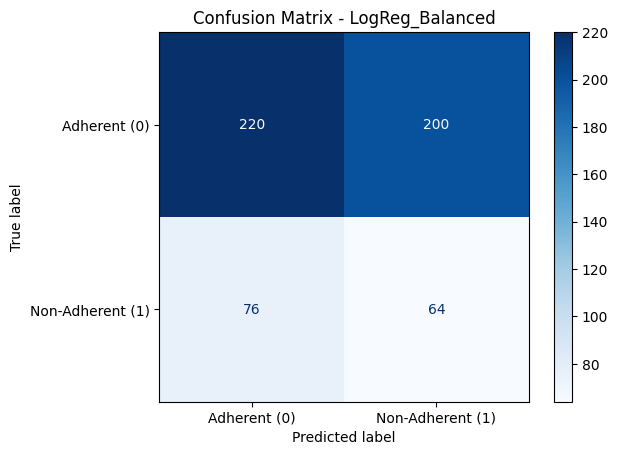

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_final)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Adherent (0)", "Non-Adherent (1)"])
disp.plot(cmap="Blues", values_format="d")
plt.title(f"Confusion Matrix - {best_model_name}")
plt.show()

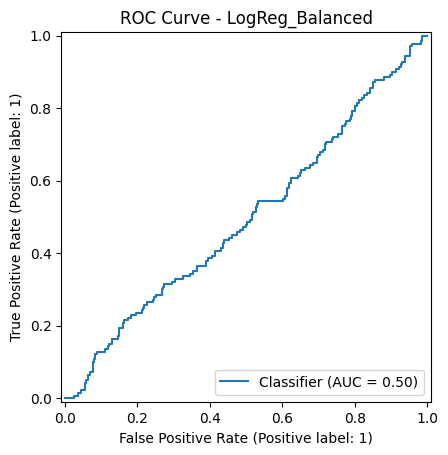

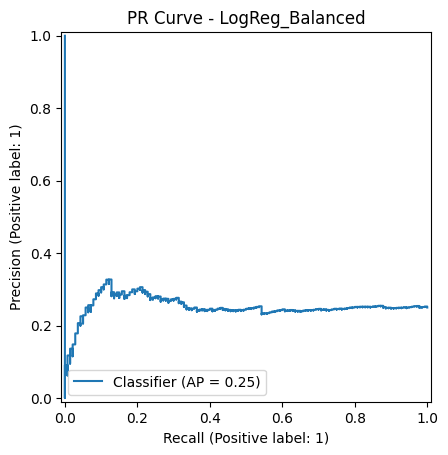

In [ ]:
# ROC & PR Curve
RocCurveDisplay.from_predictions(y_test, y_proba_final)
plt.title(f"ROC Curve - {best_model_name}")
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, y_proba_final)
plt.title(f"PR Curve - {best_model_name}")
plt.show()


Evaluasi ROS (test set):
Precision   : 0.2656
F1-Score    : 0.3434
PR-AUC      : 0.2765
Specificity : 0.5524


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


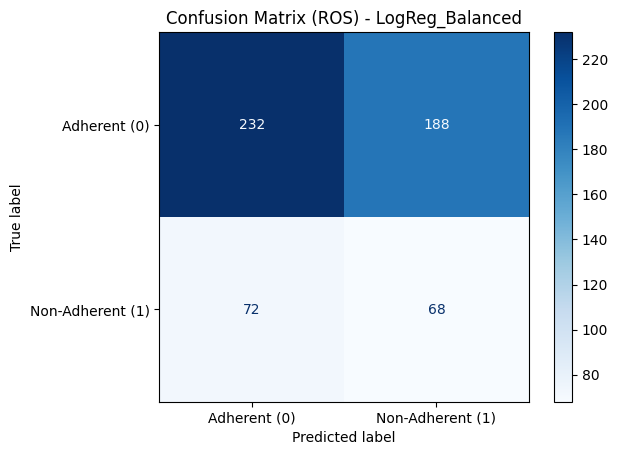

In [ ]:
# === Evaluasi dengan Random Over Sampling (ROS) ===
ros = RandomOverSampler(random_state=42)

ros_pipeline = ImbPipeline([
    ("preprocess", preprocessor),
    ("ros", ros),
    ("model", best_model),
])

ros_pipeline.fit(X_train, y_train)

y_proba_ros = ros_pipeline.predict_proba(X_test)[:, 1]
y_pred_ros = (y_proba_ros >= 0.5).astype(int)

cm_ros = confusion_matrix(y_test, y_pred_ros)
tn, fp, fn, tp = cm_ros.ravel()
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

print("\nEvaluasi ROS (test set):")
print("Precision   :", round(precision_score(y_test, y_pred_ros, zero_division=0), 4))
print("F1-Score    :", round(f1_score(y_test, y_pred_ros), 4))
print("PR-AUC      :", round(average_precision_score(y_test, y_proba_ros), 4))
print("Specificity :", round(specificity, 4))

disp_ros = ConfusionMatrixDisplay(confusion_matrix=cm_ros, display_labels=["Adherent (0)", "Non-Adherent (1)"])
disp_ros.plot(cmap="Blues", values_format="d")
plt.title(f"Confusion Matrix (ROS) - {best_model_name}")
plt.show()

## Interpretasi Hasil
- Model terbaik dipilih berdasarkan **recall** dan **F1-score** untuk menekan kasus non-adherent yang terlewat (FN).
- Hasil **Stratified 5-Fold CV** memberi gambaran kestabilan performa model sebelum diuji pada test set.
- **ROC-AUC** menunjukkan kemampuan diskriminasi kelas secara umum, sedangkan **PR-AUC** lebih informatif saat data tidak seimbang.
- **Confusion matrix** membantu melihat trade-off FP vs FN; penyesuaian threshold bisa dipakai bila perlu menaikkan recall atau precision.
- Perbandingan **Logistic Regression** vs **Decision Tree** membantu memilih model yang lebih sederhana atau lebih fleksibel sesuai kebutuhan.